# Statistical Hypothesis Testing for an A/B Test   

## Intro
 

 In this notebook, I revisited my own solution for the capstone project of the course [**A/B Testing**](https://www.udacity.com/course/ab-testing--ud257) from **School of Data Science** of _Udacity_. I added some brief literature notes on Statistical Inference, as well as plotted a few more graphics to confirm the conclusion of it.

## Index   
- [1. Summary](#1-summary)
- [2. Probabilistic approach](#2-probabilistic-approach)
- [3. Statistical approach](#3-statistical-approach)
- [4. Logistic Regression for confirmation of conclusions](#4-logistic-regression-for-confirmation-of-conclusions)
- [5. Confusion matrix and ROC Space](#5-confusion-matrix-and-roc-space)

### 1. Summary

After having obtained some synthetic data resulting from an A/B test, we are to determine whether or not a variation on the display of a website can lead to more conversions/registrations.

This notebook may be categorized into two different branches: Probability and Statistics. The former one will be rather discussed superficially, whereas the latter one will be more extended.

Once we have briefly reviewed the dataset from an probabilistic approach, we will pose the Null Hypothesis $H_0$ and apply some bootstrapping to simulate the increment of p-values from both website versions. As you may guess, we aim to determine whether or not we can fail to reject $H_0$. 

Later on, we will validate the results obtained by performing some Logistic Regressions, exploring the timestamp register, and executing some model diagnostics by means of confusion matrices and ROC spaces.

We will conclude by seeing that more inferences will be needed to decide whether or not the changes performed on the new website may increase user conversions. 

Please note that subjects such as the desirable duration of the A/B test and/or acceptable threshold of conversion improvement are out of the scope of this notebook.


[Back to Index](#index)

### 2. Probabilistic approach 

After importing all of the libraries and dependencies to be utilized, we are to de some real rapid and basic data cleaning and wrangling, if it can even be named as such: 

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


In [2]:
df = pd.read_csv('datasets/users_grouped.csv')
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,C,Previous,No
1,804228,2017-01-12 08:01:45.159739,C,Previous,No
2,661590,2017-01-11 16:55:06.154213,T,New,No
3,853541,2017-01-08 18:28:03.143765,T,New,No
4,864975,2017-01-21 01:52:26.210827,C,Previous,Yes
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,C,Previous,No
294474,945152,2017-01-12 00:51:57.078372,C,Previous,No
294475,734608,2017-01-22 11:45:03.439544,C,Previous,No
294476,697314,2017-01-15 01:20:28.957438,C,Previous,No


We note that the 1st dimension of the dataset is the total number of observations a priori, which merely arrives to 300 thousand.

We are to de some very basic data cleaning and wrangling, if it can even be named as such: 

FIrst off, any values to impute?


In [3]:
if df.isnull().values.any():
    print('Yes, value imputation must be done')
else:
    print('No values to impute')

No values to impute


We better cast the values of the column `converted` into a integer, instead of a string.


In [4]:
def converted_to_int(row):
    if row['converted'] == 'No':
        val = 0
    else:
        val = 1
    return val

df['converted_int'] = df.apply(converted_to_int,
                               axis = 1)

Or, instead of creating a new column, we could even just rewrite the same column and update accordingly our data catalog:

In [5]:
df = df.drop('converted_int', axis = 1)
df['converted'] = df.apply(converted_to_int,
                           axis = 1)

In [6]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,C,Previous,0
1,804228,2017-01-12 08:01:45.159739,C,Previous,0
2,661590,2017-01-11 16:55:06.154213,T,New,0
3,853541,2017-01-08 18:28:03.143765,T,New,0
4,864975,2017-01-21 01:52:26.210827,C,Previous,1


Let us take a look at the number of unique values to see if there are some duplicates

In [7]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

We see that there seems to be some repeated timestamps.

In [8]:
print(
    f"{'Repeated timestamps'}{df.nunique()[1] - df.nunique()[0] : > 2}"
)

Repeated timestamps 3894


A way to find these ones, is to select the users that precisely exist:
- in the `control` group within the `new` page 
- in the `treatment` group within the `previous` page 

And so this is to code:

In [9]:
df_control_new = df.query("group == 'C' & landing_page == 'New'")
df_treat_prev = df.query("group == 'T' & landing_page == 'Previous'")
not_aligned = len(df_control_new) + len(df_treat_prev)
not_aligned

3893

Alternatively, we could query this in just one line of code by using the method `groupby`: 

In [10]:
not_aligned_grouped = df.groupby(['group',
                                  'landing_page']
                                  )\
                                 ['landing_page']\
                                .count()
not_aligned_grouped

group  landing_page
C      New               1928
       Previous        145274
T      New             145311
       Previous          1965
Name: landing_page, dtype: int64

In [11]:
not_aligned == (not_aligned_grouped[0] + not_aligned_grouped[3])

True

Please notice that there is still one user which doesn't exist within this group set. 

Let us though first take care of these majority of values found so far. We are to eliminate these misleading observations as per the criteria mentioned when the repeated users were found:

In [12]:
# drop the observations whose status are mislading: T-group and previous ver. |  C-group and new ver.
df2 = df.drop(df.query('(group == "T" & landing_page == "Previous") | \
                       (group == "C" & landing_page == "New")'
                       ).index
            )

We confirm that there is nothing remaining in this portion of our dataframe:

In [13]:
df2[
    (
        (df2['group'] == 'T') == (df2['landing_page'] == 'New')
     ) == False
     ].shape[0]

0

And that of course, these observations no longer exist in our dataframe which is the object of this study:


In [14]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

We see one timestamp more than unique users. That cannot be concerning any misplacement of control-treatment groups anymore, rather than one duplication of a user_id within the correct grouping, as we suspect:

In [15]:
sum(df2.user_id.duplicated())

1

Let us spot the duplicated user:

In [16]:
df2[df2.duplicated(['user_id'],
                   keep = False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,T,New,0
2893,773192,2017-01-14 02:55:59.590927,T,New,0


In [17]:
df2 = df2.drop(df2[
                   (df2.user_id == 773192) 
                   & (df2['timestamp'] == '2017-01-14 02:55:59.590927') # drop the 1st one existing in time (date:2017-01-14)
                   ]
                   .index)

# does it check?
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,T,New,0


Before we finally diving into computing any statistic, let us double check we have not created any NaNs as a result of out little Data Manipulation for this second dataset. Is there any value to impute?

In [18]:
if df2.isnull().values.any():
    print('Yes, value imputation must be done')
else:
    print('No values to impute')

No values to impute


Moving forward, we are ready to have a quick glimpse from a Probabilistic ground.

The probability that an internet user received the new page is:

In [19]:
p_new_page = df2[
                 df2['landing_page'] == 'New'
                 ]['group']\
                 .count() \
                    / len(df2)

p_new_page.round(4)

0.5001

The probability that an individual converts regardless of the page they receive is:

In [20]:
df2.converted.mean().round(4)

0.1196

The probability that an individual from `control group` converts is:

In [21]:
df_control = df2.query('group == "C"')
control_convers = df_control.converted.mean()
control_convers.round(5)

0.12039

The probability of an individual from `treatment group` converts is:

In [22]:
df_treatment = df2.query('group == "T"')
treatment_convers = df_treatment.converted.mean()
treatment_convers.round(5)

0.11881

Having computed these two last values, we can determine the difference between them so as to asses whether or not the new website produces more conversions

In [23]:
observed_diff = treatment_convers - control_convers
observed_diff.round(6)

-0.001578

It is flagrantly obvious that, despite the new version even leads to slighter less conversion than the previous version (this is : control being higher than treatment),  there's not enough evidence to neither ascertain that the new design factually leads to less conversions. And that is why we seek responses within Statistics.

[Back to Index](#index)

### 3. Statistical approach

Let us consider that we are to make a decision solely from the findings on the dataset provided. Also, let the Null Hypothesis $H_0$ exist in terms of $p_{prev}$ and $p_{new}$, these being the converted rates for the previous and new pages, respectively. 

This is to state:


\begin{equation}
\ H_0 : p_{new} -  p_{prev} \le 0
\end{equation}


\begin{equation}
\ H_1 : p_{new} -  p_{prev} > 0
\end{equation}

Then, and always under $H_0$, we also assume that both $p_{new}$  and $p_{prev}$ have _true_ success rates and these both are also equal to the **converted** success rate, _regardless of page_. 


We will then perform a sampling distribution for the difference in converted rate between the two pages over 10,000 iterations of calculating an estimate from $H_0$,.

First off, we are to retrieve $p_{new}$ as we computed previously. That was to code :

In [24]:
p_new = df2['converted'].sum() / len(df2)
p_prev = p_new
p_new.round(6)

0.119597

Please note as mentioned some cells above, $p_{prev}$ equals to $p_{new}$. Moving foward, what are $n_{prev}$ and $n_{new}$?

In [25]:

n_new = len(df2.query("landing_page == 'New'"))

# ...or using shape property as a subscriptable object, we can code:
n_prev  = df2.query("landing_page == 'Previous'").shape[0]

print(
    f"{'n_prev:'}{n_prev : > 2}",
    f"\n{'n_new:'}{n_new : > 2}",
)

n_prev: 145274 
n_new: 145310


A easier and more visual manner to select these values results when we code:

In [26]:
df2.groupby(['group', 'landing_page'])['landing_page'].count()

group  landing_page
C      Previous        145274
T      New             145310
Name: landing_page, dtype: int64

Let us simulate $n_{new}$ transactions with a convert rate of $p_{new}$. We will store these $n_{new}$ 1's and 0's in `new_page_converted` variable, as follows :

In [27]:
new_sample = df_treatment.sample(n_new,
                                 replace = True)
new_page_converted = new_sample['converted']
p_new = new_page_converted.mean()
p_new.round(4)

0.1191

Then we are to proceed the same manner with the old website:

In [28]:
prev_sample = df_control.sample(n_prev,
                                 replace = True)
prev_page_converted = new_sample['converted']
p_prev = prev_page_converted.mean()
p_prev.round(4)

0.1191

We can see then the difference between these two values

In [29]:
simulated_p_diff = p_new - p_prev
simulated_p_diff.round(9)

0.0

And here is where the usefulness of bootstrapping holds a crucial role in order to get the Sampling Distribution in Hypothesis Testing. We are to simulate over 10000 values of the differences of conversions between both pages:

In [30]:
p_diff = []
control_conv_prob = []
treatment_conv_prob = []
repeats = 10000 

for _ in range(repeats):
    sample_prev = df_control.sample(n_prev,
                              replace = True)
    sample_new = df_treatment.sample(n_new,
                                replace = True)

    control_conversion = sample_prev['converted'].sum() / n_prev
    treatment_conversion = sample_new['converted'].sum() / n_new

    treatment_conv_prob.append(treatment_conversion)
    control_conv_prob.append(control_conversion)
    p_diff.append(treatment_conversion - control_conversion)
    
p_diff = np.array(p_diff)

Please note that we could have utilized the numpy function `binomial` to compute the control and treatment conversions,  but that would have consumed even more time and memory.

Before we analyze these increments of p-values `p_diffs` between different pages, let us briefly plot a histogram with both of these distributions:  


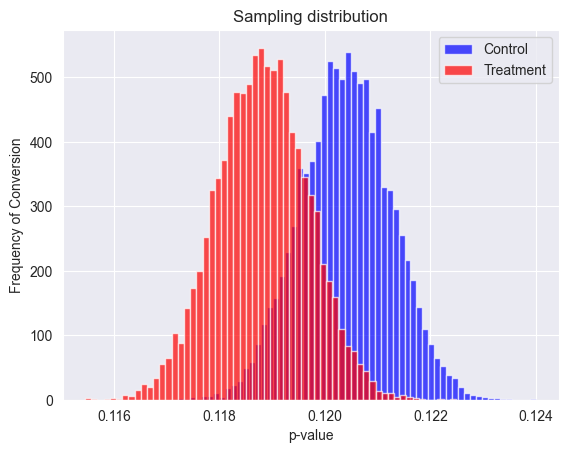

In [92]:
plt.hist(control_conv_prob, label = 'Control',
         alpha=.7, bins = 60,  color='blue')
plt.hist(treatment_conv_prob, label = 'Treatment',
         alpha=.7, bins = 60, color='red')
plt.title('Sampling distribution')
plt.xlabel('p-value')
plt.ylabel('Frequency of Conversion')
plt.legend();

 We are to find the probability that this difference of p-values is less or equal to zero ( existance of $H_0$ ):

In [32]:
stats.percentileofscore(p_diff, 0).round(4)
# or, for the same end,  (p_diffs < 0).mean() for a per-unitary value

90.44

This is indicating that - and **solely as an indication of the weight of the evidence in favour of $H_0$** - there would be around a 90% of chance that the difference between p-values is less or equal to zero, and so that we would fail to reject $H_0$.

 We can visualize this by rendering the following plot if we code :

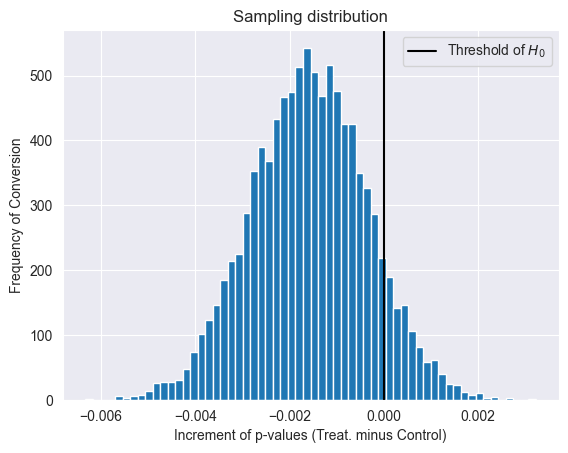

In [91]:
plt.hist(p_diff, bins = 60)

# setting the threshold value, as per $H_0$
plt.axvline(x = 0, color='black', label = 'Threshold of $H_0$')

plt.title('Sampling distribution')
plt.xlabel("Increment of p-values (Treat. minus Control)")
plt.ylabel('Frequency of Conversion')
plt.legend();

In [34]:
stats.percentileofscore(p_diff, 0)

90.44

In [35]:
 p_diff.std().round(6)

0.00123

Let us visualize a normal distribution centered in the std of this new increment of p-values `p_diff` found by means of bootstrap distribution. We are also to plot the previously found `observed_diff` we found in the probabilistic section:  as well as the threshold from which we would be able to reject $H_0$ :

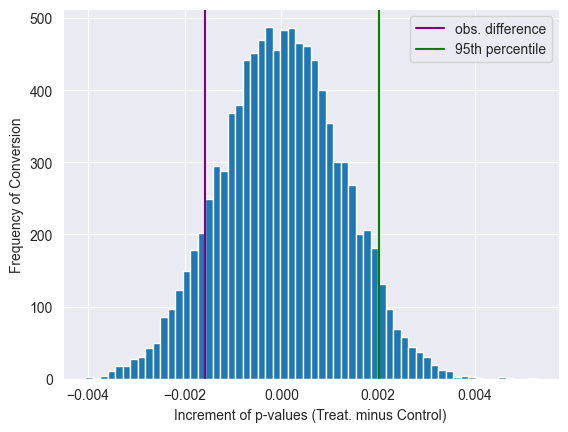

In [88]:
random.seed(42)
null_vals = np.random.normal(0, p_diff.std(), repeats)
percent_95th = np.percentile(null_vals, 95)

plt.hist(null_vals, bins = 60)

plt.axvline(x = observed_diff, color='purple', label = 'obs. difference')
plt.axvline(x = percent_95th,
            color='green' , label = '95th percentile')
plt.xlabel("Increment of p-values (Treat. minus Control)")
plt.ylabel('Frequency of Conversion')
plt.legend();

In [37]:
print(
    f"{'observed_diff:'}{observed_diff.round(4) : > 2}",
    f"\n{'percent_95th:'}{percent_95th.round(4) : > 2}",
)

observed_diff:-0.0016 
percent_95th: 0.002


This is merely stating that we would be only able to reject $H_0$ if the observed difference was higher than .002

Next, let us compute the proportion of the difference of p-values `p_diff` which are greater than the actual or observed difference in our dataset :

In [38]:
(p_diff > observed_diff).mean()

0.5002

And considering the N distribution centered in the std of `p_diff` ,  this proportion results to be:

In [39]:
p_value = (null_vals > observed_diff).mean()
p_value

0.9016

Or analogously using _statsmodels_:

In [40]:
p_value = 1 - stats.percentileofscore(null_vals, observed_diff) / 100
p_value.round(4)

0.9016

We would only be able to reject the null if the observed difference was higher than:

In [41]:
np.percentile(null_vals, 95).round(8)

0.00202789

And in both cases, Probabilistic and Hypothesis Testing, these values result to be:

In [42]:
print(
    f"{'observed_diff (Probabilistic):'}{observed_diff.round(5).round(4) : > 2}",
    f"\n{'p_diff (Hypothesis Testing):'}{ p_diff.std().round(6) : > 2}"
)

observed_diff (Probabilistic):-0.0016 
p_diff (Hypothesis Testing): 0.00123


We then still fail to reject $H_0$ - considering a Type I error rate of 5% - and hence,  there are no reasons to not keep the previous website.

We could reach similar conclusions while keeping our code shorter through the use of the statsmodels module and its built-in fuctions. Therefore, we are to calculate the number of conversions for each page, as well as the number of individuals who received each page. 

Let n_prev and n_new refer the  number of rows associated with the previous page and new pages, respectively.

In [43]:
convert_prev = df2.query('(converted == 1) & (group == "C")').count()
convert_new = df2.query('(converted == 1) & (group == "T")').count()

n_prev = df2.query('group == "C"').count()
n_new = df2.query('group == "T"').count()

We define the arguments to be used by utilizing the same nomenclature as in the _statsmodels_ literature:

In [44]:
counts = [convert_new.iloc[0],
          convert_prev.iloc[0]]

nobs = [n_new.iloc[0],
        n_prev.iloc[0]]

We then are ready to compute the test for proportions based on normal (z) test:


In [45]:

z_score, p_value = sm.stats.proportions_ztest(counts,
                                              nobs,
                                              alternative = 'larger') # hyp.it's one-tailed (smaller or equal than zero)

# for a Type I error rate of 5%
critical_value = norm.ppf(1 - (0.05))

print(
    f"\n{'p_value:'}{p_value.round(4) : > 2}",
    f"\n{'z_score:'}{z_score.round(4) : > 2}",
    f"\n{'critical_value:'}{critical_value.round(4) : > 2}"
)


p_value: 0.9051 
z_score:-1.3109 
critical_value: 1.6449


We are still unable to reject $H_0$ for the z-score is lower than the critical value defined by the 5% Type I error we mentioned earlier.

Let us plot this findings in a Density plot for a random normal distribution. For the argument "size", we will pass the value of the variable  `repeats` we utilized when bootstraping:


z_score:-1.3109 
critical_value: 1.6449


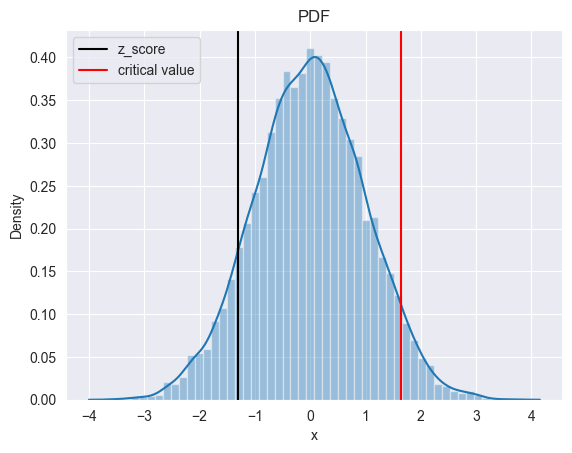

In [46]:
# density plot
g = sns.distplot(np.random.normal(0, 1, repeats))
g.axvline(x = z_score, color='black', label = 'z_score')
g.axvline(x = critical_value, color='red', label = 'critical value')
plt.title('PDF')
plt.xlabel("x")
plt.ylabel('Density')
plt.legend(loc = 'upper left')
print(
    f"\n{'z_score:'}{z_score.round(4) : > 2}",
    f"\n{'critical_value:'}{critical_value.round(4) : > 2}"
);

Likewise for a Cumulative Distribution Function:

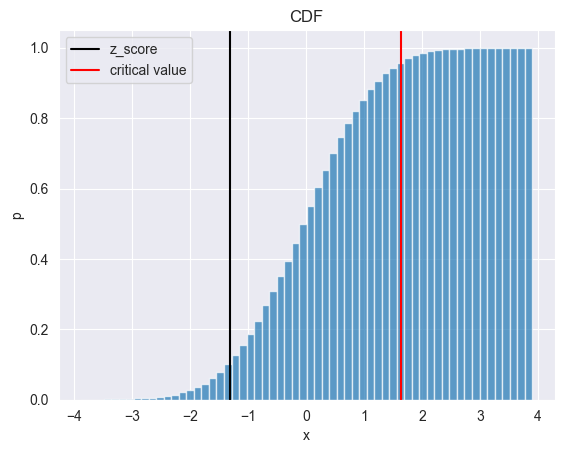

In [47]:
# cdf plot
plt.hist(np.random.normal(0, 1, repeats),
         cumulative = True, density = True, 
         bins = 60, alpha = .7
        )

plt.axvline(x = z_score, label = 'z_score',
            color = 'black')
plt.axvline(x = critical_value, label = 'critical value',
            color = 'red')
plt.title('CDF')
plt.xlabel('x')
plt.ylabel('p')
plt.legend(loc = 'upper left');

Let us compute and locate the percentile in which z-score is found:

In [48]:
# z-score is on the 10th percentile of the distribution 
z_score_percentile = norm.cdf(z_score)
z_score_percentile.round(4)

0.0949

In [49]:
# p-value can be calculated as follows from the z-score
p_value = 1 - z_score_percentile
p_value.round(4)

0.9051

And so, we can ascertain that there is insufficient evidence to support the notion that the new page results in increased conversions. Hence, maintaining the previous page is most advisable.

In order to visualize this, we are to take a regression approach to conclude this notebook.

[Back to Index](#index)

### 4. Logistic Regression for confirmation of conclusions


Since the object of our analysis is a discrete variable, the type of regression to used shall be Logistic. We are to check by means of Logistic Regression the findings already discussed so far.

We will be employing _statsmodels_ and  _sklearn_ for fitting the regression model outlined in the probabilistic approach. This aims to determine whether there is a noteworthy variation in conversion depending on the page a customer is assigned. 

Nonetheless, before proceeding, it is essential to define two new columns: an `intercept` column and a dummy variable column `ab_page` indicating the page each user is to be assigned. This is, for the latter, it will take a value of 1 when an website visitor receives the treatment version, or 0 if it's redirected to the previous ( control ) version group.

In [50]:
df2.columns

Index(['user_id', 'timestamp', 'group', 'landing_page', 'converted'], dtype='object')

In [51]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'],
                                dtype = int )['T']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,C,Previous,0,1,0
1,804228,2017-01-12 08:01:45.159739,C,Previous,0,1,0
2,661590,2017-01-11 16:55:06.154213,T,New,0,1,1
3,853541,2017-01-08 18:28:03.143765,T,New,0,1,1
4,864975,2017-01-21 01:52:26.210827,C,Previous,1,1,0


In [52]:
logit_m = sm.Logit(df2['converted'],
                   df2[
                       ['intercept','ab_page']
                      ]
                  )
results = logit_m.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [53]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 23 Dec 2023   Pseudo R-squ.:               8.077e-06
Time:                        11:42:27   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

Please note that this is a **two-tailed hypothesis test** with two different critical regions. These are: "the new page leads to significanlty greater or smaller conversion rates". In contrast, in our previous **one-tailed hypothesis test**, this region was confined in only one side of the normal distribution, this being "the new website has higher conversion rate than the previous one".

Let us plot this to have a better concept:


2.5th percentile: -0.002429
Observed_diff: -0.001578
97.5th percentile: 0.002408


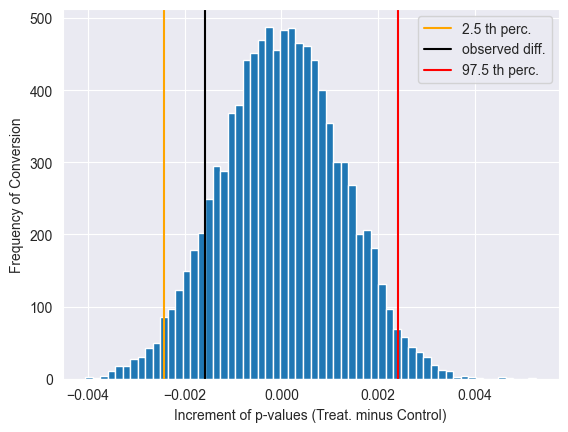

In [90]:
plt.hist(null_vals, bins = 60)

plt.axvline(x = np.percentile(null_vals, 2.5), color='orange', label = '2.5 th perc.')
plt.axvline(x = observed_diff, color='black', label = 'observed diff.')
plt.axvline(x = np.percentile(null_vals, 97.5), color='red', label = '97.5 th perc.')
plt.legend(loc='upper left', borderpad= .7,
           labelspacing = 1, fontsize='small')

print('2.5th percentile:', np.percentile(null_vals, 2.5).round(6))
print('Observed_diff:', np.percentile(observed_diff, 2.5).round(6))
print('97.5th percentile:', np.percentile(null_vals, 97.5).round(6))

plt.xlabel("Increment of p-values (Treat. minus Control)")
plt.ylabel('Frequency of Conversion')
plt.legend();



In a two-tailed hypothesis test, we would reject the  $H_0$ if and when the observed conversion difference was either lower than the 2.5th percentile or higher than the 97.5th one.

Please note we are somewhat closer to the rejection region in comparsion with the one-sided hypothesis test, and that's related to the fact that our p-value has also decreased.

Moving forward, a decisive point in Hypothesis Testing is to consider is which factors take into consideration when designing a model.
There are certainly various factors that we could include beyond just the website change that may influence user conversion, such as existing customer behavior, change aversion, or other metrics. 

However, some of the drawbacks of introducing more terms to the regression model is having to deal with the well know [Multiple comparisons](https://en.wikipedia.org/wiki/Multiple_comparisons_problem). Additionally, adding numerous independent variables may lead to overfitting and other potential issues like [Multicollinearity](https://online.stat.psu.edu/stat462/node/177/), the appearance of [Confounding factors](https://www.statisticshowto.com/experimental-design/confounding-variable/) or even the existance of [Simpson's paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox) happening mostly within the existance of aggregared groups of data.

After importing our last dataset, we are to join it to our exisiting one, and apply some One-Hot Encoding to the categorical data for each country the user is accessing the website from. 

This is to code the following:

In [55]:
df_countries = pd.read_csv('datasets/countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [56]:
df_countries['country'].value_counts()

country
US    203619
UK     72466
CA     14499
Name: count, dtype: int64

In [57]:
df_new = df_countries.set_index('user_id')\
                     .join(df2.set_index('user_id'),
                           how ='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,C,Previous,0,1,0
928468,US,2017-01-23 14:44:16.387854,T,New,0,1,1
822059,UK,2017-01-16 14:04:14.719771,T,New,1,1,1
711597,UK,2017-01-22 03:14:24.763511,C,Previous,0,1,0
710616,UK,2017-01-16 13:14:44.000513,T,New,0,1,1


In [58]:
df_new['country'].value_counts()

country
US    203619
UK     72466
CA     14499
Name: count, dtype: int64

We notice that there are almost 3 time more US users than English or Canadian, therefore we will make the calculations using these two latter ones.

Let us one-hot encode these 3 columns and join them into our dataset:

In [59]:
# perform one-hot encoding on 'country' column
dummy_countries = pd.get_dummies(df_new['country'],
                                 dtype = int)

# Define the final dataset 'df_reg' we're going to work with 
# by joining these one-hot encoded dummy vars
df_reg = dummy_countries.join(df_new,
                         how = 'inner')
df_reg.head()

,CA,UK,US,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,,,,
834778,0,1,0,UK,2017-01-14 23:08:43.304998,C,Previous,0,1,0
928468,0,0,1,US,2017-01-23 14:44:16.387854,T,New,0,1,1
822059,0,1,0,UK,2017-01-16 14:04:14.719771,T,New,1,1,1
711597,0,1,0,UK,2017-01-22 03:14:24.763511,C,Previous,0,1,0
710616,0,1,0,UK,2017-01-16 13:14:44.000513,T,New,0,1,1


Next, we will consider the converted column as the dependent variable, and 'UK', 'CA' and 'intercept' the external or independent ones:

In [60]:
logit_m1 = sm.Logit(df_reg['converted'], # dependble var
                    df_reg[
                          ['intercept', 'UK', 'CA'] # indepenent ones
                          ]
                    )
results1 = logit_m1.fit()
results1.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sat, 23 Dec 2023   Pseudo R-squ.:               1.521e-05
Time:                        11:42:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
==============================================================================
"""

In [61]:
np.exp(results.params).round(4)

intercept    0.1369
ab_page      0.9851
dtype: float64

In [62]:
logit_m2 = sm.Logit(df_reg['converted'],
                    df_reg[
                            ['intercept','ab_page',
                            'UK','CA']
                          ]
                    )
results2 = logit_m2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 23 Dec 2023   Pseudo R-squ.:               2.323e-05
Time:                        11:42:31   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
==============================================================================
"""

In [63]:
np.exp(results2.params).round(4)

intercept    0.1368
ab_page      0.9852
UK           1.0099
CA           0.9601
dtype: float64

In [64]:
# conversions from the new website version of UK and CA , respectively

df_reg['UK_new'] = df_reg['ab_page'] * df_reg['UK'] 
df_reg['CA_new'] = df_reg['ab_page'] * df_reg['CA']

In [65]:
df_reg.head()

,CA,UK,US,country,timestamp,group,landing_page,converted,intercept,ab_page,UK_new,CA_new
user_id,,,,,,,,,,,,
834778,0,1,0,UK,2017-01-14 23:08:43.304998,C,Previous,0,1,0,0,0
928468,0,0,1,US,2017-01-23 14:44:16.387854,T,New,0,1,1,0,0
822059,0,1,0,UK,2017-01-16 14:04:14.719771,T,New,1,1,1,1,0
711597,0,1,0,UK,2017-01-22 03:14:24.763511,C,Previous,0,1,0,0,0
710616,0,1,0,UK,2017-01-16 13:14:44.000513,T,New,0,1,1,1,0


In [66]:
logit_m3 = sm.Logit(df_reg['converted'],
                    df_reg[['intercept',
                            'UK', 'CA',
                            'UK_new', 'CA_new']])
results3 = logit_m3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Sat, 23 Dec 2023   Pseudo R-squ.:               2.417e-05
Time:                        11:42:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2729
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
UK             0.0045      0.018      0.257      0.797      -0.030       0.039
CA            -0.0073      0.037     -0.196      0.844      -0.080       0.065
UK_new         0.0108      0.023      0.475      0.635      -0.034       0.056
CA_new        -0.0674      0.052     -1.297      0.195      -0.169       0.034
==============================================================================
"""

In [67]:
np.exp(results3.params).round(4)

intercept    0.1358
UK           1.0045
CA           0.9927
UK_new       1.0109
CA_new       0.9348
dtype: float64

In [68]:
# we added ab_page column, could we ommit previous fit operation?
logit_m4 = sm.Logit(df_reg['converted'],
                    df_reg[['intercept', 'ab_page',
                            'UK', 'CA',
                            'UK_new', 'CA_new']])
results4 = logit_m4.fit()
results4.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 23 Dec 2023   Pseudo R-squ.:               3.482e-05
Time:                        11:42:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK_new         0.0314      0.027      1.181      0.238      -0.021       0.084
CA_new        -0.0469      0.054     -0.872      0.383      -0.152       0.059
==============================================================================
"""

In [69]:
np.exp(results4.params).round(4)

intercept    0.1372
ab_page      0.9796
UK           0.9943
CA           0.9826
UK_new       1.0319
CA_new       0.9542
dtype: float64

To conclude this section, let us consider in our Logit Results the information of the timestamp column. 
We are to create new bucket columns depending on the hour of visit by performing One-Hot Encoding again via lambda functions. 

In [70]:
# Cast the nature of the timestamp column to ns whose type can be dealt by numPy
df_reg['timestamp'] = df_reg['timestamp'].astype('datetime64[ns]')

# Let us recall the date range of our dataset:
print('Date range:\
      \nStart:',
       min(df_reg['timestamp'].dt.date),
      '\nEnd:',
       max(df_reg['timestamp'].dt.date)
       )


Date range:      
Start: 2017-01-02 
End: 2017-01-24


In [71]:
# we get the hour from timestamp col.
df_reg['hour'] = df_reg['timestamp'].dt.hour

# and one-hot encode them based on the hour-buckets coded below
df_reg['midnight'] = df_reg.apply(lambda row: 1 if (row.hour > 0 and row.hour < 5) 
                               else 0, axis = 1)

df_reg['morning'] = df_reg.apply(lambda row: 1 if (row.hour >= 5 and row.hour < 9)
                                 else 0, axis = 1)

df_reg['midday'] = df_reg.apply(lambda row: 1 if (row.hour >= 9 and row.hour < 13)
                                else 0, axis = 1)

df_reg['afternoon'] = df_reg.apply(lambda row: 1 if (row.hour >= 13 and row.hour < 17)
                                   else 0, axis = 1)

df_reg['evening'] = df_reg.apply(lambda row: 1 if (row.hour >= 17 and row.hour < 21) 
                                 else 0, axis = 1)

df_reg['night'] = df_reg.apply(lambda row: 1 if (row.hour >= 21 or row.hour == 0)
                                     else 0, axis = 1)

df_reg.head()

,CA,UK,US,country,timestamp,group,landing_page,converted,intercept,ab_page,UK_new,CA_new,hour,midnight,morning,midday,afternoon,evening,night
user_id,,,,,,,,,,,,,,,,,,,
834778,0,1,0,UK,2017-01-14 23:08:43.304998,C,Previous,0,1,0,0,0,23,0,0,0,0,0,1
928468,0,0,1,US,2017-01-23 14:44:16.387854,T,New,0,1,1,0,0,14,0,0,0,1,0,0
822059,0,1,0,UK,2017-01-16 14:04:14.719771,T,New,1,1,1,1,0,14,0,0,0,1,0,0
711597,0,1,0,UK,2017-01-22 03:14:24.763511,C,Previous,0,1,0,0,0,3,1,0,0,0,0,0
710616,0,1,0,UK,2017-01-16 13:14:44.000513,T,New,0,1,1,1,0,13,0,0,0,1,0,0


In [72]:
# having any or all of 'ab_page', 'UK', 'CA', 'UK_newpage', 'CA_newpage' makes no difference to significance of time buckets
logit_m5 = sm.Logit(df_reg['converted'], df_reg[['intercept', 'ab_page', 'UK', 'CA', 'UK_new', 'CA_new',
                                           'night', 'morning', 'midday', 'afternoon', 'midnight']])
results5 = logit_m5.fit()
results5.summary()

Optimization terminated successfully.
         Current function value: 0.366074
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290573
Method:                           MLE   Df Model:                           10
Date:                Sat, 23 Dec 2023   Pseudo R-squ.:               0.0001298
Time:                        11:42:55   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                  0.002083
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9725      0.016   -123.900      0.000      -2.004      -1.941
ab_page       -0.0207      0.014     -1.513      0.130      -0.047       0.006
UK            -0.0059      0.019     -0.311      0.755      -0.043       0.031
CA            -0.0176      0.038     -0.468      0.640      -0.092       0.056
UK_new         0.0318      0.027      1.196      0.232      -0.020       0.084
CA_new        -0.0468      0.054     -0.870      0.384      -0.152       0.059
night          0.0017      0.020      0.084      0.933      -0.037       0.040
morning       -0.0142      0.020     -0.719      0.472      -0.053       0.024
midday         0.0122      0.020      0.619      0.536      -0.026       0.051
afternoon     -0.0169      0.020     -0.857      0.391      -0.056       0.022
midnight      -0.0678      0.020     -3.399      0.001      -0.107      -0.029
==============================================================================
"""

In [73]:
np.exp(results5.params).round(4)

intercept    0.1391
ab_page      0.9795
UK           0.9942
CA           0.9825
UK_new       1.0323
CA_new       0.9543
night        1.0017
morning      0.9859
midday       1.0122
afternoon    0.9832
midnight     0.9345
dtype: float64

We are still obtaining odd ratios upclose to the unity, therefore this results can't contribute to discern any different result obtained from both website versions in terms of conversions/registrations.

We see that the odds ratio in all cases happen to be very close to the unity.HEnce, this model and/ or the dataset obtained cannot help us ascertain whether or not the new website version leads to more conversions/ registrations.

Before we move onto the section of ROC space and Confusion matrix, we are to visualize the visits and conversion for the available dataset.

In [74]:
# Cast the nature of the timestamp column to ns whose type can be dealt by numPy
df_reg['timestamp'] = df_reg['timestamp'].astype('datetime64[ns]')

# Let us recall the date range of our dataset:
print('Date range:\
      \nStart:',
       min(df_reg['timestamp'].dt.date),
      '\nEnd:',
       max(df_reg['timestamp'].dt.date)
       )


Date range:      
Start: 2017-01-02 
End: 2017-01-24


In [75]:
# we will reindex when grouping by days of the week using
# the following variable later on
days = ['Monday','Tuesday','Wednesday',
        'Thursday','Friday','Saturday',
        'Sunday']

#  let us define the day of the week
day_week = df_reg['timestamp'].dt.day_name()
day_week.head()


user_id
834778    Saturday
928468      Monday
822059      Monday
711597      Sunday
710616      Monday
Name: timestamp, dtype: object

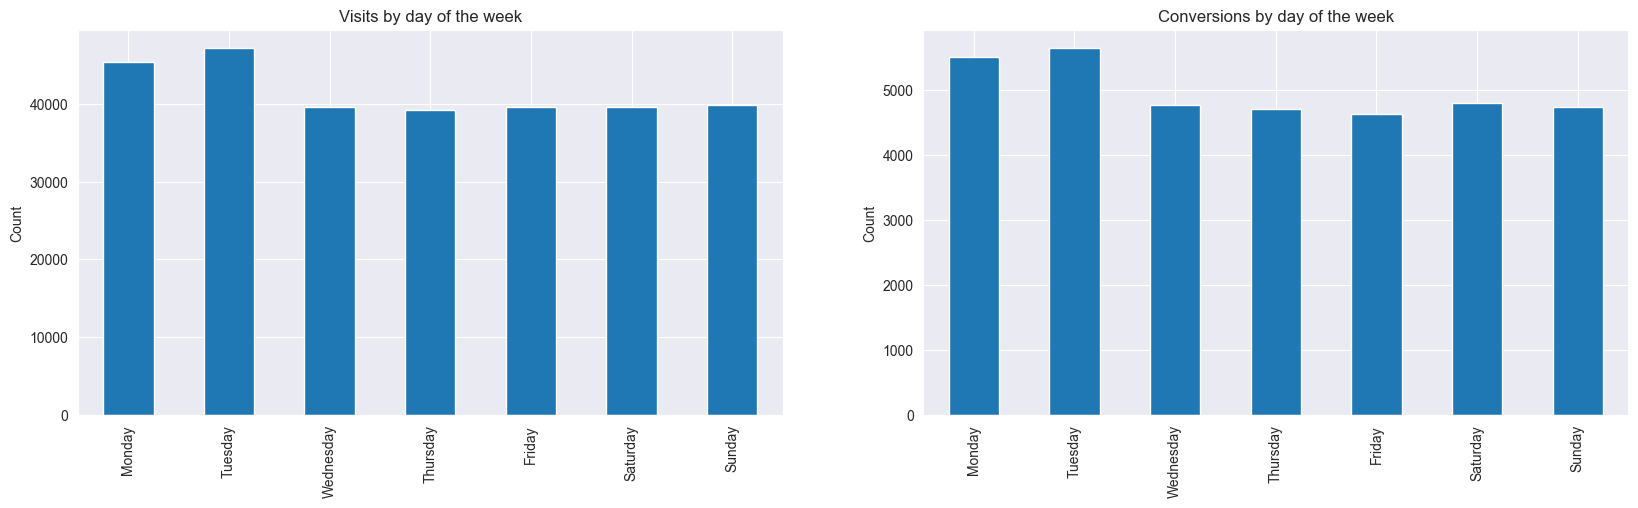

In [76]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
g2 = df_reg.groupby(day_week)\
           .count()['converted']\
           .reindex(days)\
           .plot(kind = "bar")
g2.set(title = 'Visits by day of the week',
       xlabel = '',
       ylabel = 'Count')

plt.subplot(1,2,2)
g234 = df_reg.groupby(day_week)['converted']\
           .agg(np.sum)\
           .reindex(days)\
           .plot(kind = "bar", 
                 xlabel = '',
                 ylabel = 'Count')
g234.set(title = 'Conversions by day of the week');

In [77]:
# let us define now the variable for the day of the month
day_num = df_reg['timestamp'].dt.day
day_num.head()

user_id
834778    14
928468    23
822059    16
711597    22
710616    16
Name: timestamp, dtype: int32

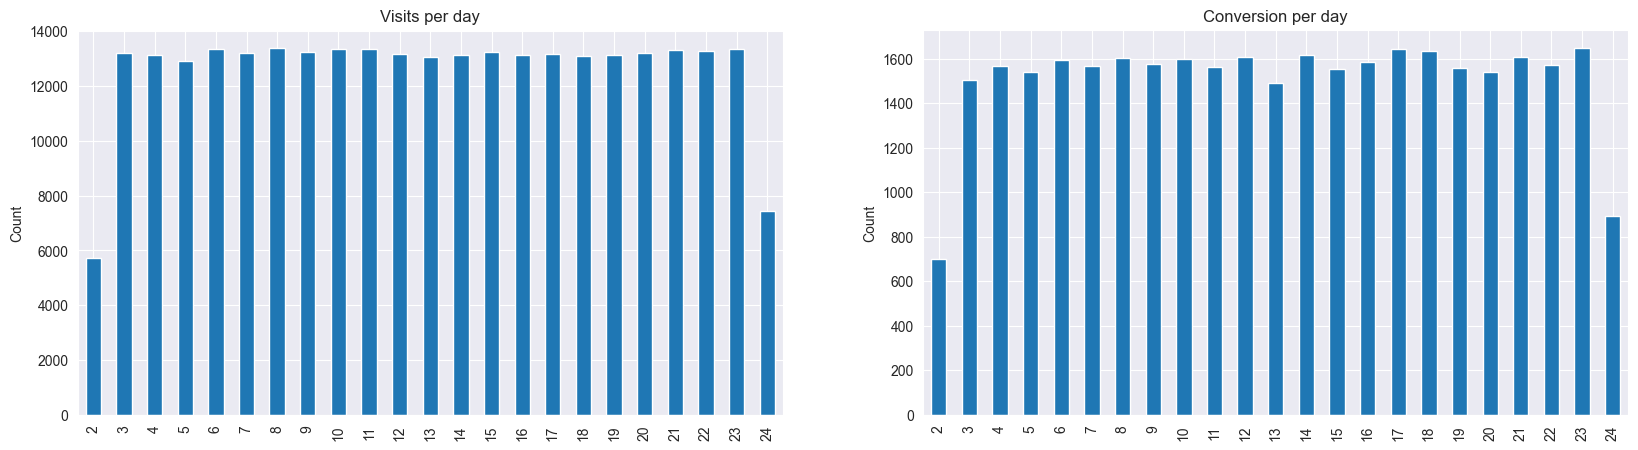

In [78]:
plt.figure(figsize = (20,5))

plt.subplot(1,2,1)
g1 = df_reg.groupby(day_num)\
           .count()['converted']\
           .plot(kind = "bar")
g1.set(title = 'Visits per day',
       xlabel = '',
       ylabel = 'Count')

plt.subplot(1,2,2)
g112 = df_reg.groupby(day_num)['converted']\
           .agg(np.sum)\
           .plot(kind = "bar",
                 xlabel = '',
                 ylabel = 'Count')
g112.set(title = 'Conversion per day');

[Back to Index](#index)



### 5. Confusion matrix and ROC Space


In this final part, we are to plot a confusion matrix and ROC space in order to see the statistical power of a models generated with LogisticRegression using sklearn :


In [79]:
# model diagnostics # Reduced
X = df_reg[['ab_page', 'UK', 'CA', 'UK_new', 'CA_new']]
y = df_reg['converted']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = .2,
                                                    random_state = 0)

In [80]:

log_mod8 = LogisticRegression()
log_mod8.fit(X_train, y_train)
preds = log_mod8.predict_proba(X_test)

preds

array([[0.87989381, 0.12010619],
       [0.88156031, 0.11843969],
       [0.88156031, 0.11843969],
       ...,
       [0.88156031, 0.11843969],
       [0.88156031, 0.11843969],
       [0.87957483, 0.12042517]])

In [81]:
# we extrac the probabilities of conversion
y_prob = []
for index, item in enumerate(preds):
    y_prob.append(item[1])
y_prob = pd.Series(y_prob)

# and set a new threshold 'p_conv_thres' for the prediction,
# otherwise, all our predicted-converted values will equal to zero
p_conv_thres = .12
y_preds = (y_prob > p_conv_thres).astype('int')
y_preds.value_counts()

1    34785
0    23332
Name: count, dtype: int64

In [82]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.88      0.40      0.55     51094
           1       0.12      0.61      0.20      7023

    accuracy                           0.43     58117
   macro avg       0.50      0.50      0.38     58117
weighted avg       0.79      0.43      0.51     58117



In [83]:
# precision = TP / (TP + FP)
print('Precision:', precision_score(y_test, y_preds).round(4))

# recall = TP / (TP + FN)
print('Recall:', recall_score(y_test, y_preds).round(4))

# accuracy = (TP + TN) / (TP + FP + FN + TN)
score = accuracy_score(y_test, y_preds)

print('Accuracy:', score.round(4))

Precision: 0.1224
Recall: 0.6063
Accuracy: 0.4272


In [84]:
cm2 = confusion_matrix(y_test,y_preds)
cm2

array([[20567, 30527],
       [ 2765,  4258]], dtype=int64)

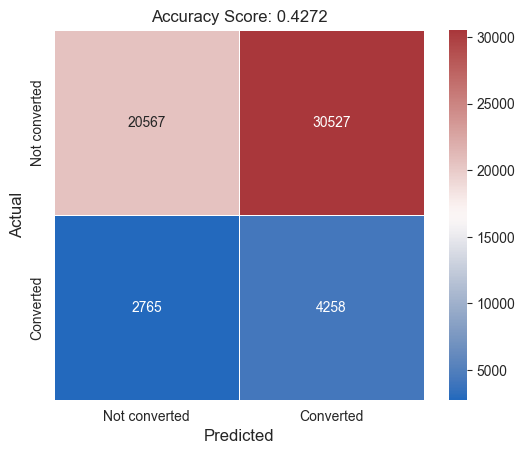

In [85]:
ax= plt.subplot()
sns.heatmap(cm2, annot = True, fmt=".0f",
            lw = .5, square = True,
cmap = 'vlag')
plt.ylabel('Actual', size = 12)
plt.xlabel('Predicted', size = 12)
all_sample_title = 'Accuracy Score: {0}'.format(score.round(4))
plt.title(all_sample_title, size = 12)
ax.xaxis.set_ticklabels(['Not converted', 'Converted'])
ax.yaxis.set_ticklabels(['Not converted', 'Converted']);


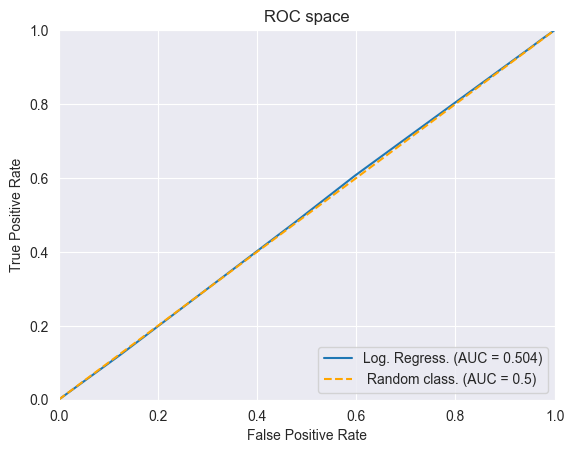

In [86]:
# Receiver Operating Characteristic space

# compute
logit_roc_auc = roc_auc_score(y_test, y_preds)
fpr, tpr, thresholds = roc_curve(y_test, log_mod8.predict_proba(X_test)[ :, 1])

# plot rendering
plt.figure()
plt.plot(fpr, tpr, label = 'Log. Regress. (AUC = %0.3f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'--', color = 'orange', label =' Random class. (AUC = 0.5)')

plt.xlim([0, 1])
plt.xlabel('False Positive Rate')

plt.ylim([0, 1])
plt.ylabel('True Positive Rate')

plt.title('ROC space')
plt.legend(loc = "lower right")
plt.show();

Although there is just a smidgen of inclination towards the TPR side, the AOC is almost equivalent to the one of the baseline or Random Model in the ROC space. Hence, this model can't predict whether ot not the new version has greater or less conversion rate in comparison with the previous website.

In conclusion, we confirm that it can't be demonstrated that the new website version leads to a higher conversion rate. Therefore, maintaining the previous version is the safest option to stay with. 

Thank you for reading this notebook!

[Back to Index](#index)